Unravelling with the V-model with just one bath

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from _utils import *
from FCS import *

In [20]:
# Define system parameters
N = 3 # Number of levels
nu = 1 # Frequency of the system
a = 0.04
delta = 0.03
# alpha = 0.5 # No right bath for now
betaL = 1/4
# betaR = 1/3.99 # No right bath for now

# Define the parameters for the V-model
params = {'nu': nu, 'a': a, 'delta': delta, 'beta': betaL}

# Set up the open system problem with one bath at temperature 1/betaL
g_ops, H_uni, c_ops_uni = V_model_1bath(**params, kind='unified')
g_ops, H_sec, c_ops_sec = V_model_1bath(**params, kind='secular')

# Define the steady state density operators
rho_ss_uni = steadystate(H_uni, c_ops_uni)
rho_ss_sec = steadystate(H_sec, c_ops_sec)

In [21]:
# We want to unravel the master equation

t0, tf = 0, 300
dt = 0.01
tlist = np.arange(t0, tf, dt)
# tlist = np.logspace(-1, np.log10(tf), 10000)

g1, g2, g3 = g_ops

# Start the system in a pure state
# psi_init = (g2 + g3)/np.sqrt(2)
psi_init = g1
rho_init = psi_init*psi_init.dag()

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
result_sec = photocurrent_mesolve(H_sec, rho_init, tlist, sc_ops=c_ops_sec, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)

Total run time:   0.20s
Total run time:   0.29s


In [22]:
# Get all the expectation values
g1_evo_uni = result_uni.expect[0]
g2_evo_uni = result_uni.expect[1]
g3_evo_uni = result_uni.expect[2]
g32_evo_uni = result_uni.expect[3]

g1_evo_sec = result_sec.expect[0]
g2_evo_sec = result_sec.expect[1]
g3_evo_sec = result_sec.expect[2]
g32_evo_sec = result_sec.expect[3]

In [23]:
# Analytic solution for the non-conditional coherence (from Felix's work)

k = a*nu*BoseEinsteinDistribution(nu,betaL)
phi = k*(1 + 2*np.exp(-betaL*nu))
tau = (2*k*(1+np.exp(-betaL*nu)))/(delta**2*(1 + 2*np.exp(-betaL*nu)))
g32_analytic = ((phi - k)/(2*(phi + k)))*(np.exp(-tlist/tau)-np.exp(-(phi + k)*tlist))


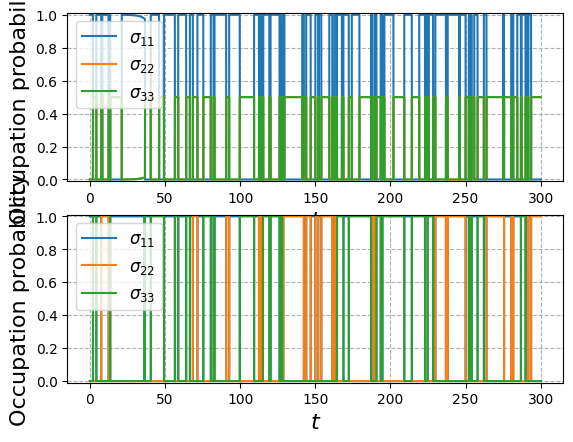

In [24]:
# Plot the populations

plt.subplot(211)
plt.plot(tlist, g1_evo_uni, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_uni, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_uni, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g1_evo_sec, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_sec, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_sec, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

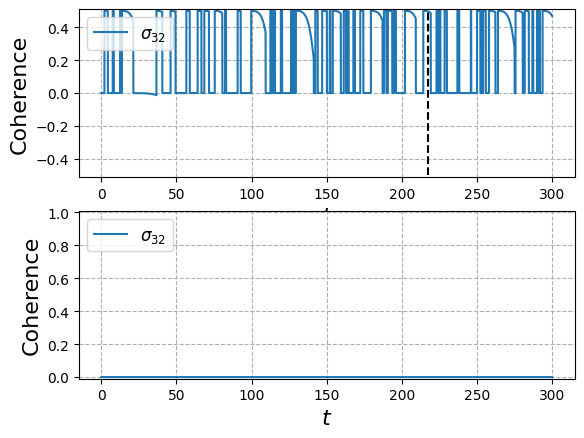

In [90]:
# Plot the coherences

plt.subplot(211)
plt.plot(tlist, g32_evo_uni, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.511, 0.51)

plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])

plt.subplot(212)

plt.plot(tlist, g32_evo_sec, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

In [91]:
# Let's build the non-conditional density operator by averaging over an ensemble of trajectories, for comparison to the solution of the QME
# Unified only, we know the secular equation will give simple behaviour for the coherence

N = 100 # Number of trajectories in the ensemble

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni_ensemble = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=200, noise=13, store_measurement=True)

10.0%. Run time:   7.13s. Est. time left: 00:00:01:04
20.0%. Run time:  13.40s. Est. time left: 00:00:00:53
30.0%. Run time:  19.46s. Est. time left: 00:00:00:45
40.0%. Run time:  26.70s. Est. time left: 00:00:00:40
50.0%. Run time:  34.05s. Est. time left: 00:00:00:34
60.0%. Run time:  46.26s. Est. time left: 00:00:00:30
70.0%. Run time:  54.61s. Est. time left: 00:00:00:23
80.0%. Run time:  67.09s. Est. time left: 00:00:00:16
90.0%. Run time:  76.63s. Est. time left: 00:00:00:08
Total run time:  81.65s


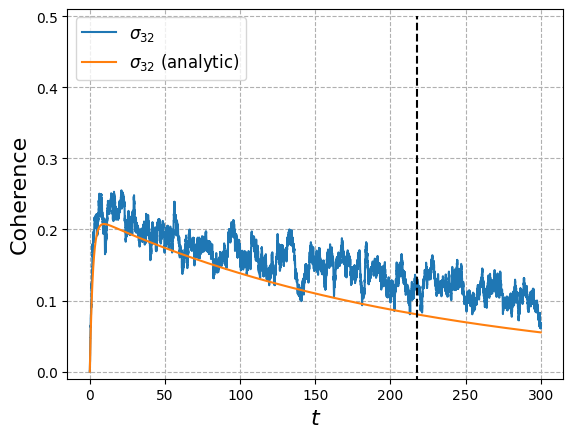

In [92]:
# Plot coherence for the ensemble


g32_evo_uni_ensemble = result_uni_ensemble.expect[3]




plt.figure()
plt.plot(tlist, g32_evo_uni_ensemble, label=r'$\sigma_{32}$')
plt.plot(tlist, g32_analytic, label=r'$\sigma_{32}$ (analytic)')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 0.51)

plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])


plt.show()

In [105]:
# Manually average over a bunch of trajectories and confirm it matches photocurrent_mesolve with multiple trajectories

results = []
for i in range(100):
    result_uni_single = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=1, noise=i, store_measurement=True)
    results.append(result_uni_single.expect[3])

avg_results = [sum(col)/len(col) for col in zip(*results)]

plt.plot(tlist, avg_results)
plt.plot(tlist, g32_analytic, label=r'$\sigma_{32}$ (analytic)')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.511, 0.51)
plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])

plt.show()


Total run time:   0.36s
Total run time:   0.33s
Total run time:   0.40s
Total run time:   0.43s
Total run time:   0.35s
Total run time:   0.38s
Total run time:   0.35s
Total run time:   0.37s
Total run time:   0.35s
Total run time:   0.41s
Total run time:   0.39s
Total run time:   0.37s
Total run time:   0.33s
Total run time:   0.36s
Total run time:   0.35s
Total run time:   0.32s
Total run time:   0.35s
Total run time:   0.33s
Total run time:   0.33s
Total run time:   0.37s
Total run time:   0.37s
Total run time:   0.37s
Total run time:   0.36s
Total run time:   0.35s
Total run time:   0.35s
Total run time:   0.33s
Total run time:   0.31s
Total run time:   0.32s
Total run time:   0.32s
Total run time:   0.34s
Total run time:   0.40s
Total run time:   0.43s
Total run time:   0.36s
Total run time:   0.38s
Total run time:   0.35s
Total run time:   0.36s
Total run time:   0.36s
Total run time:   0.34s
Total run time:   0.41s
Total run time:   0.45s
Total run time:   0.39s
Total run time: 